# Convolutional Neural Network (CNN)

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/02_deeplearning/02_cnn/cnn.ipynb)

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

# Import jax eco-system
import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.training import train_state
from flax import struct
import optax

from clu import metrics

## 0. Train parameters

In [2]:
NUM_CLASSES = 10
BATCH_SIZE = 64
NUM_EPOCHS = 10
LR = 5e-4

## 1. Prepare dataset

In [3]:
# Get train/test datasets and convert them into iterable batches
def get_datasets(num_epochs, batch_size):

    # Dataset classes
    classes = np.array([
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ])
    
    # downoad Cifar-10 dataset
    train_ds = tfds.load('cifar10', split='train')
    test_ds = tfds.load('cifar10', split='test')

    def normalize_img(img):
        new_img = tf.cast(img, tf.float32) / 255.
        # new_img = tf.image.per_image_standardization(new_img)
        return new_img
    
    # Mapping images as tf tensor
    train_ds = train_ds.map(lambda sample: {'image': normalize_img(sample['image']),
                                            'label': sample['label']})
    
    test_ds = test_ds.map(lambda sample: {'image': normalize_img(sample['image']),
                                            'label': sample['label']})

    # Tensorflow dataloader
    train_ds = train_ds.repeat(num_epochs).shuffle(1024)
    train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1)
    test_ds = test_ds.shuffle(1024)
    test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

    return classes, train_ds, test_ds

checking datasets and labels.

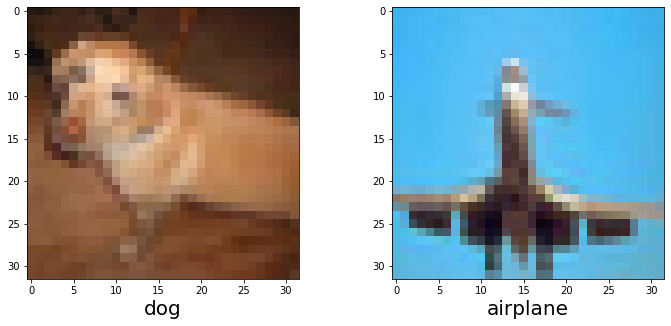

In [4]:
classes, train_ds, test_ds = get_datasets(10, 32)

# Get a single batch of data from both datasets
check_train = next(iter(train_ds))
check_test = next(iter(test_ds))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# display the images and corresponded labels
axes[0].imshow(check_train['image'][0])
axes[0].set_xlabel(classes[check_train['label'][0].numpy()], fontsize=20)
axes[1].imshow(check_test['image'][0])
axes[1].set_xlabel(classes[check_test['label'][0].numpy()], fontsize=20)

plt.show()

In [5]:
print(check_train['image'].numpy().shape)

(32, 32, 32, 3)


## 2. Define the MLP network

In [6]:
class CNN(nn.Module):
    num_classes:int
    
    @nn.compact
    def __call__(self, x, train:bool):
        
        # Conv. Block 1
        x = nn.Conv(features=32, kernel_size=(3, 3), strides=1)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x)

        # Conv. Block 2
        x = nn.Conv(features=32, kernel_size=(3, 3), strides=2)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x)

        # Conv. Block 3
        x = nn.Conv(features=64, kernel_size=(3, 3), strides=1)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x)

        # Conv. Block 4
        x = nn.Conv(features=64, kernel_size=(3, 3), strides=2)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x)

        # Flatten
        x = x.reshape(x.shape[0], -1)

        # Fully-connected Network
        x = nn.Dense(features=128)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x)
        x = nn.Dropout(rate=0.5, deterministic=not train)(x)

        # Output
        x = nn.Dense(features=self.num_classes)(x)
        return x

Model summary in JAX:

In [7]:
cnn = CNN(NUM_CLASSES)
print(cnn.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 32, 32, 3)), train=False)) # shape: (batch, h, w, channel)


                                                      CNN Summary                                                       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ path        ┃ module    ┃ inputs               ┃ outputs             ┃ params                   ┃ batch_stats        ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│             │ CNN       │ - float32[1,32,32,3] │ float32[1,10]       │                          │                    │
│             │           │ - train: False       │                     │                          │                    │
├─────────────┼───────────┼──────────────────────┼─────────────────────┼──────────────────────────┼────────────────────┤
│ Conv_0      │ Conv      │ float32[1,32,32,3]   │ float32[1,32,32,32] │ bias: float32[32]        │                    │
│             │           │    

## 3. Creating a `TrainState`

A common pattern in Flax is to create a single dataclass that represents the entire training state, including step number, parameters, and optimizer state.

In [8]:
from typing import Any

@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
    metrics: Metrics
    batch_stats: Any  # batch_stat for BatchNormalization Layers
    key: jax.random.KeyArray # random key for Dropout Layers

def create_train_state(module, params_key, dropout_key, learning_rate, train=False):
    # First initialize the model with random parameters
    variables = module.init(params_key, jnp.ones([1, 32, 32, 3]), train=False)
    params = variables['params']
    batch_stats = variables['batch_stats']

    # Initialize optimizer
    tx = optax.adam(learning_rate=learning_rate)
    return TrainState.create(
            apply_fn=module.apply,
            params=params,
            batch_stats=batch_stats,
            key=dropout_key,
            tx=tx,
            metrics=Metrics.empty())

## 4. Train steps
1. Evaluate the neural network with parameters and a batch of input images with `TrainState.apply_fn()`;
2. Compute cross entropy loss using `optax.softmax_cross_entropy_with_integet_labels()`;
3. Evaluate the gradient of the loss function using `jax.grad()`;
4. Apply a pytree of gradients to the optimizer to update the model's parameter.

In [9]:
@jax.jit
def train_step(state, batch):
    # fold in dropout keys for Dropout layers
    dropout_train_key = jax.random.fold_in(key=state.key, data=state.step)
    
    def loss_fn(params):
        logits, updates = state.apply_fn(
            {'params': params, 'batch_stats': state.batch_stats}, 
            batch['image'],
            train=True,
            rngs={'dropout': dropout_train_key},
            mutable=['batch_stats'],
            )
        
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch['label']).mean()
        
        return loss, (logits, updates)
        
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (logits, updates)), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    # Update batch_stats
    state = state.replace(batch_stats=updates['batch_stats'])
    
    return state

## 5. Computing metrics

In [10]:
@jax.jit
def compute_metrics(*, state, batch):
    
    logits = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats}, 
        batch['image'],
        train=False)
    
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()

    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=batch['label'], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

## 6. Load dataset and initialize the `TrainState`

In [11]:
classes, train_ds, test_ds = get_datasets(NUM_EPOCHS, BATCH_SIZE)

tf.random.set_seed(0)
# Initialize random keys for the model
root_key = jax.random.PRNGKey(0)
main_key, params_key, dropout_key = jax.random.split(key=root_key, num=3)

state = create_train_state(cnn, params_key, dropout_key, LR)
del root_key

## 7. Train and evaluate

In [12]:
num_steps_per_epoch = train_ds.cardinality().numpy() // NUM_EPOCHS

metrics_history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': []
}

In [13]:
for step, batch in enumerate(train_ds.as_numpy_iterator()):
    # Training
    state = train_step(state, batch)
    state = compute_metrics(state=state, batch=batch)

    # Evaluate the model at each epoch
    if (step + 1) % num_steps_per_epoch == 0:
        for metric, value in state.metrics.compute().items():
            metrics_history[f'train_{metric}'].append(value)
        state = state.replace(metrics=state.metrics.empty())

        test_state = state
        for test_batch in test_ds.as_numpy_iterator():
            test_state = compute_metrics(state=test_state, batch=test_batch)

        for metric, value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        print('Epoch {}:'.format((step + 1) // num_steps_per_epoch))
        print(f'\tTrain - loss: {metrics_history["train_loss"][-1]:.4f}, accuracy: {metrics_history["train_accuracy"][-1]*100:.4f}')
        print(f'\tTest - loss: {metrics_history["test_loss"][-1]:.4f}, accuracy: {metrics_history["test_accuracy"][-1]*100:.4f}')

Epoch 1:
	Train - loss: 1.5729, accuracy: 43.4639
	Test - loss: 1.1570, accuracy: 58.3934
Epoch 2:
	Train - loss: 0.9911, accuracy: 64.9408
	Test - loss: 0.9722, accuracy: 65.6150
Epoch 3:
	Train - loss: 0.8257, accuracy: 71.0707
	Test - loss: 0.9099, accuracy: 68.0889
Epoch 4:
	Train - loss: 0.7293, accuracy: 74.4758
	Test - loss: 0.8270, accuracy: 70.1422
Epoch 5:
	Train - loss: 0.6445, accuracy: 77.3748
	Test - loss: 0.8202, accuracy: 71.2139
Epoch 6:
	Train - loss: 0.5572, accuracy: 80.6758
	Test - loss: 0.8196, accuracy: 71.7448
Epoch 7:
	Train - loss: 0.4936, accuracy: 83.0006
	Test - loss: 0.8192, accuracy: 72.4559
Epoch 8:
	Train - loss: 0.4198, accuracy: 85.5534
	Test - loss: 0.9140, accuracy: 69.5012
Epoch 9:
	Train - loss: 0.3811, accuracy: 87.0078
	Test - loss: 0.9104, accuracy: 70.8333
Epoch 10:
	Train - loss: 0.3412, accuracy: 88.2462
	Test - loss: 0.8619, accuracy: 72.6562


## 8. Visualize metrics

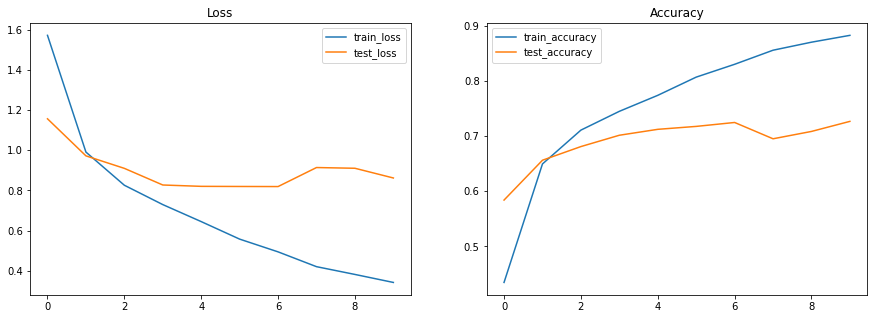

<Figure size 432x288 with 0 Axes>

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')

ax1.legend()
ax2.legend()
plt.show()
plt.clf()

## 9. Check predictions

In [15]:
test_batch = tfds.as_numpy(next(iter(test_ds)))

logits = state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats}, test_batch['image'], train=False)
preds = logits.argmax(-1)

true_labels = test_batch['label']
imgs = test_batch['image']

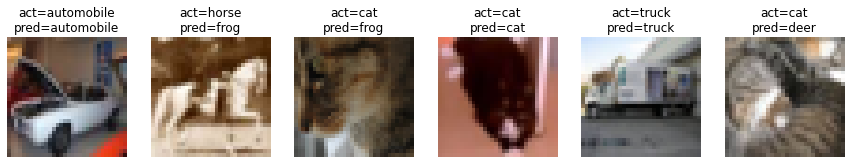

In [16]:
num_to_show = 6
indices = np.random.choice(np.arange(len(imgs)), num_to_show, replace=True)

fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i, idx in enumerate(indices):
    img = imgs[i]
    ax = fig.add_subplot(1, num_to_show, i+1, label='test')
    ax.axis('off')
    
    pred_class = classes[preds[i]]
    true_class = classes[true_labels[i]]
    
    ax.imshow(img)
    ax.set_title(f'act={true_class}\npred={pred_class}')

plt.show()